### Applications of Statistical Learning Methods to Free Energy Calculations and Protein Structural Analysis

Molecular dynamics (MD) simulations have been playing a crucial role in various disciplines of science in the past decades, including chemistry, physics, and biology. However, to gain more insights into the system of interest, appropriate data analysis must be carried out. This project demonstrates two cases of how statistical learning methods, either a supervised learning method (multiple linear regression) or an unsupervised learning method (principal component analysis) can be applied to facilitate the exploration of MD simulation data. Starting from a simple system composed of a NaCl and water molecules, we first show how a simple statistical learning method like multiple linear regression can tackle a more complex problem like free energy calculations in the first section. Then, in the second section, we focus on the simulation data of a more complicated structure Bacteriophage T4 Lysozyme, a protein with 162 residues, using principal component analysis (PCA) to analyze the protein structure throughout the trajectory simulated. In addition to Python, we also use GROMACS commands and Visual Molecular Dynamics (VMD) to analyze the data. All of the simulation data and relevant files can be downloaded from the [GitHub repository](https://github.com/wehs7661/Stats_Final_Project) for this project.

### Section 1. Free Energy Calculation by Umbrella Sampling and Multiple Linear Regression

#### 1.1 Introduction
One of the well-known restrictions on the usefulness of a molecular dynamics (MD) simulation is the kinetic bottlenecks commonly observed in systems characterized by numerous metastable states separated by a high energy barrier. The very low probability of crossing the energy barrier makes it nearly impossible for an ordinary MD simulation to obtain a comprehensive review of the free energy surfaces (FES) of proteins, which enables valuable insights into quantitative relationships between structures, dynamics, stability, and functional behaviors of proteins. 

To address the challenges associated with the sampling of phase space and the calculation of the corresponding free energy of complex systems, a variety of advanced sampling techniques have been proposed over the years, including adaptive biasing force, replica exchange, umbrella sampling, and metadynamics, etc. As one of the advanced sampling techniques, umbrella sampling (US) is an algorithm in which biased potentials are added as a form of harmonic restraint to enforce the exploration of regions of interest. In the umbrella sampling, multiple window simulations are required to obtain the local probability distributions at different values of collective variables. Subsequently, we typically use the weighted histogram analysis method (WHAM) or multistate Bennett Acceptance Ratio (MBAR) to stitch these probability distributions and compute the potential of mean force (PMF). 

However, the reweighting histogram method can be computationally expensive because of numerous iterations to satisfy the self-consistent condition when the number of relevant collective variables (CVs) is huge. This motivates an efficient multiple linear regression (MLR) framework to link the biased probability distributions of individual umbrella windows. Inspired and rationalized by the work by Maragliano and Vanden-Eijnden[[1]](https://aip.scitation.org/doi/full/10.1063/1.2907241), Meng et. al approximated PMF as a linear combination of radial basis Gaussian functions[[2]](https://pubs.acs.org/doi/abs/10.1021/ct501130r). Based on the theory proposed in this work, the same methodology was applied to a simple NaCl system to compute the PMF as a function of the ion-pair distance in this section. 

#### 1.2 An Overview of the System
The simulation data used in this section was from my research work, which can be used to determine the PMF of a system composed of a NaCl and water molecules. In the umbrella sampling simulation, 47 umbrella windows were defined at different values of reaction coordinate, which is the ion-pair distance between the sodium ion and the chloride ion. The value of the collective variable ranges from $0.265 nm$ to $0.981$ $nm$, with $0.015$ $nm$ spacing between windows. For each umbrella window, an ordinary MD simulation was perform at $300$ $K$ with the force constant as $10000$ $kJ/(mol \cdot nm^{2})$. At last, to calculate PMF, we need the "pullx" data files with the file names in the form of `pullx-umbrella{i}.xvg` with i ranging from 0 to 46, which contain the value of reaction coordinate as a function of time for each umbrella window.

#### 1.3 Theorectical Backgrounds
In the umbrella sampling simulations, the PMF ($W(x)$) along the collective variable(s) $x$ can be written as: 
\begin{equation}
W(x)=-k_{B}T \ln P^{(0)}(x)=-k_{B}T \ln P^{(b)}(x) -U^{(b)}(x)+F
\end{equation}

Where $k_{B}$ is the Boltzmann constant, $T$ is the temperature of the system, $P^{(0)}$ is the unbiased probability distrubtion function (PDF), $P^{(b)}$ is the biased PDF from an umbrella window, $U$ is the potential energy, and $F$ is an undertermined factor. 
<br>As mentioned above, the PMF can be approximated as a linear combination of radial basis Gaussian functions. That is, the PMF can be expressed as 
\begin{equation}
W(x)=\sum_{m=1}^{M}a_{m}g_{m}(x), g_{m}(x)=exp(-(x-\mu)^{2}/2\sigma_{m}^{2})
\end{equation}
Where $a_{m}$ is the weight (amplitude) of the Gaussian function $g_{m}(x)$ centered at $x_{m}$ with a variance/width of $\sigma_{m}^{2}$. 
<br>Since the factor $F$ in the expression of $W(x)$ depends on biased potential and varies from window from window, a direct fitting to the absolute value of the PMF is not feasible. We calculate the difference in PMF as follows instead: 
\begin{equation}
\Delta W = W(x_{2})-W(x_{1})=\sum_{m=1}^{M}a_{m}(g_{m}(x_{2})-g_{m}(x_{1})
\end{equation} 
Since $\Delta W = -k_{B}Tln[P^{(b)}(x_{2})/P^{(b)}(x_{1})]-[U^{(b)}(x_{2})-U^{(b)}(x_{1})]$, we have 
\begin{equation}
-k_{B}T \ln [P^{(b)}(x_{2})/P^{(b)}(x_{1})]-[U^{(b)}(x_{2})-U^{(b)}(x_{1})] = \sum_{m=1}^{M}a_{m}(g_{m}(x_{2})-g_{m}(x_{1})) + \epsilon
\end{equation}
Where $\epsilon$ is the residual error, which should be minimized in the calculation. If the mean and the variance of Gaussian basis functions are not included in the fitting, a multivariate linear regression model of the form $\bf{y=M \cdot a + \epsilon }$ is obtained, which is the model that we fitted the data to in this section.


#### 1.4 Multiple Linear Regression (MLR) 

Our goal here is to fit the data to the regression model as follows:
<br>$-k_{B}T \ln [P^{(b)}(x_{2})/P^{(b)}(x_{1})]-[U^{(b)}(x_{2})-U^{(b)}(x_{1})] = \sum_{m=1}^{M}a_{m}(g_{m}(x_{2})-g_{m}(x_{1})) + \epsilon \Rightarrow \bf{y=M \cdot a + \epsilon }$

#### 1.4.1 Module loading and data inputs

First, we load the modules and set up the constants and parameters involved and the arrays to be stored data.

In [88]:
import numpy as np
import random # for subsampling
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.linear_model import LinearRegression
random.seed(2020)
%matplotlib inline

In [89]:
# Constants.
# Note: Unit for energy calculation below: kBT (kB=1.38e-23 J/K, T=300K)
N = 47 # number of umbrellas
K = 3000 # number of data points for each umbrella 
nbins = 30  # number of bins per simulation
G = 200 # number of Gaussians
Nmax = 3770 # don't hard code.
rmin = 0.25
rmax = 1.00
width = (rmax-rmin)/G  # width of the Gaussian-basis function

# Allocate storage for simulation data
x_kn = np.zeros([N,K]) # x_kn[k,n] is the m-th data point of ion-pair distance (in nm) from the n-th umbrella simulation
xc = np.zeros(N) # xc_kn[k,n] is the center location (in nm) for the n-th umbrella window (all k points have same mu)
xc_kn = np.zeros([N,K]) # xc_kn[k,n] is the center location (in nm) for the n-th umbrella window (all k points have same mu)
mu_kg = np.zeros([G,K])

Then, we read in the input data, which is a seris of `pull.xvg` files containing the value of reaction coordinate as a function of time for each umbrella window. Note that each the `.xvg` file has different number of data point. The shortest one is pullx-umbrella31.xvg, whic only contain 3770 data points (`N_max=3770`, simulation time: 7.538 ns), so here we first read in 3770 points for each window.

In [90]:
pull_data = np.zeros([N,Nmax])
for n in range(N):
    # Read ion-pair distance data.
    filename = 'Section 1/pullx-umbrella%d.xvg' % n
    infile = open(filename, 'r')
    lines = infile.readlines()
    infile.close()
    # Parse data.
    i = 0
    j = 0
    for line in lines:
        if line[0] == '#' or line[0] == '@':
            j +=1 #number of parameter lines

    for line in lines[j:j+Nmax]: #read in data starting from (j+1)-th line and read in 5000 lines in total (read in 5000 points)
        if line[0] != '#' and line[0] != '@':
            tokens = line.split()
            dist = float(tokens[1]) # ion-pair distance
            pull_data[n,i] = dist
            
            i += 1 
pull_data

array([[0.259691, 0.264714, 0.258843, ..., 0.266757, 0.285173, 0.2773  ],
       [0.273646, 0.283738, 0.272026, ..., 0.28443 , 0.280405, 0.277866],
       [0.285662, 0.292421, 0.298753, ..., 0.257703, 0.2926  , 0.262522],
       ...,
       [0.974082, 0.992242, 0.989893, ..., 0.95706 , 0.992987, 0.967136],
       [0.944431, 0.92831 , 0.92153 , ..., 0.936133, 0.923881, 0.961075],
       [0.972262, 0.974487, 0.99608 , ..., 0.97353 , 0.958042, 0.952319]])

Then, we randomly select K=3000 data points from each window and assign them to the matrix `x_kn` and `X`.

In [91]:
for i in range(N):
    x_kn[i,:] = random.choices(pull_data[i], k=K)   # pull_data[i] --> dataset for umbrella i
print(x_kn)
X = x_kn.reshape(1, K*N)
print(X)

[[0.281063 0.272341 0.264463 ... 0.259984 0.26361  0.27901 ]
 [0.27466  0.283527 0.266435 ... 0.272202 0.294243 0.281623]
 [0.299525 0.296055 0.282788 ... 0.280856 0.273863 0.297761]
 ...
 [0.984105 0.966758 0.97024  ... 0.980986 0.963001 0.976758]
 [0.927186 0.953432 0.918869 ... 0.933558 0.945937 0.938487]
 [1.00812  0.970752 1.00362  ... 0.980198 0.993909 0.976528]]
[[0.281063 0.272341 0.264463 ... 0.980198 0.993909 0.976528]]


To calculate PMF curve, we still need the centers of each umbrella window, which can actually be extrated from the `pullx.xvg` files. To be more specific, the value of $x$ at the 0-th time frame in the `pullx-umbrella{i}.xvg` file is the center of the i-th umbrella window, since at $t=0$, the pulling force had not been applied.

In [92]:
center = np.zeros(N)
for i in range(N):
    center[i] = pull_data[i][0]
center

for n in range(N):
    xc[n] = pull_data[n][0]
    xc_kn[n] = xc[n]

Xc = xc_kn.reshape(1, K*N)
print(xc)
print(xc_kn)

[0.259691 0.273646 0.285662 0.312992 0.317119 0.376427 0.33443  0.379999
 0.394165 0.399779 0.443105 0.487607 0.488173 0.507479 0.494456 0.511567
 0.521172 0.548665 0.535872 0.553132 0.594269 0.600382 0.61587  0.628457
 0.626779 0.679292 0.680011 0.68082  0.679195 0.745899 0.738039 0.751918
 0.763903 0.77605  0.807711 0.77961  0.83922  0.837554 0.858907 0.855993
 0.87198  0.935294 0.904561 0.923475 0.974082 0.944431 0.972262]
[[0.259691 0.259691 0.259691 ... 0.259691 0.259691 0.259691]
 [0.273646 0.273646 0.273646 ... 0.273646 0.273646 0.273646]
 [0.285662 0.285662 0.285662 ... 0.285662 0.285662 0.285662]
 ...
 [0.974082 0.974082 0.974082 ... 0.974082 0.974082 0.974082]
 [0.944431 0.944431 0.944431 ... 0.944431 0.944431 0.944431]
 [0.972262 0.972262 0.972262 ... 0.972262 0.972262 0.972262]]


#### 1.4.2 Generation of matrices 

Before we generate the matrix required for the regression model, let's think about this matrices more thoroughly. Remember that we have 47 umbrellas (`N=47`), 3000 data points per each umbrella (K=3000, so 141000 data points in total) and the regression model as $-k_{B}T \ln [P^{(b)}(x_{2})/P^{(b)}(x_{1})]-[U^{(b)}(x_{2})-U^{(b)}(x_{1})] = \sum_{m=1}^{M}a_{m}(g_{m}(x_{2})-g_{m}(x_{1})) + \epsilon \Rightarrow \bf{y= a \cdot M + \epsilon }$
<br> Where $g_{m}(x)=\exp(-\frac{(x-\mu_{m})^{2}}{2\sigma_{m}^{2}})$ for the **m-th Gaussian**. ($\mu_{m}$ is the center of the m-th Gaussian.)
<br>Note that the number of Gaussians need not to be the same as the number of umbrella windows. Taking $x_{1}$ as the center of the umbrella window $\{x_{c,1}, x_{c,2}, ..., x_{c,47}\}$ and using 200 Gaussians, the $\bf{M}$ matrix can be written as:

\begin{equation}
M = \begin{bmatrix} 
g_{1}(x_{1,window1})-g_{1}(x_{c,1}) & g_{2}(x_{1,window1})-g_{2}(x_{c,1}) & \dots & g_{200}(x_{1,window1})-g_{200}(x_{c,1})  \\
g_{1}(x_{2,window1})-g_{1}(x_{c,1}) & g_{2}(x_{2,window1})-g_{2}(x_{c,1}) & \dots & g_{200}(x_{2,window1})-g_{200}(x_{c,1}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window1})-g_{1}(x_{c,1})& g_{2}(x_{3000,window1})-g_{2}(x_{c,1})& \dots & g_{200}(x_{3000,window1})-g_{47}(x_{c,1}) \\
g_{1}(x_{1,window2})-g_{1}(x_{c,2})& g_{2}(x_{1,window2})-g_{2}(x_{c,2})& \dots & g_{200}(x_{1,window2})-g_{200}(x_{c,2}) \\
g_{1}(x_{2,window2})-g_{1}(x_{c,2})& g_{2}(x_{2,window2})-g_{2}(x_{c,2})& \dots & g_{200}(x_{2,window2})-g_{200}(x_{c,2}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window2})-g_{1}(x_{c,2})& g_{2}(x_{3000,window2})-g_{2}(x_{c,2})& \dots & g_{200}(x_{3000,window2})-g_{47}(x_{c,2}) \\
g_{1}(x_{1,window3})-g_{1}(x_{c,3})& g_{2}(x_{1,window3})-g_{2}(x_{c,3})& \dots & g_{200}(x_{1,window3})-g_{200}(x_{c,3}) \\
g_{1}(x_{2,window3})-g_{1}(x_{c,3})& g_{2}(x_{2,window3})-g_{2}(x_{c,3})& \dots & g_{200}(x_{2,window3})-g_{200}(x_{c,3}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window47})-g_{1}(x_{c,47})& g_{2}(x_{3000,window47})-g_{2}(x_{c,47})& \dots & g_{200}(x_{3000,window47})-g_{200}(x_{c,47}) \\
\end{bmatrix}
\end{equation}

Here, we let 

\begin{equation}
M_{1} = \begin{bmatrix} 
g_{1}(x_{1,window1}) & g_{2}(x_{1,window1}) & \dots & g_{200}(x_{1,window1}) \\
g_{1}(x_{2,window1}) & g_{2}(x_{2,window1}) & \dots & g_{200}(x_{2,window1}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window1}) & g_{2}(x_{3000,window1}) & \dots & g_{200}(x_{3000,window1}) \\
g_{1}(x_{1,window2}) & g_{2}(x_{1,window2}) & \dots & g_{200}(x_{1,window2})  \\
g_{1}(x_{2,window2}) & g_{2}(x_{2,window2}) & \dots & g_{200}(x_{2,window2})  \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window2}) & g_{2}(x_{3000,window2}) & \dots & g_{200}(x_{3000,window2}) \\
g_{1}(x_{1,window3}) & g_{2}(x_{1,window3}) & \dots & g_{200}(x_{1,window3}) \\
g_{1}(x_{2,window3}) & g_{2}(x_{2,window3}) & \dots & g_{200}(x_{2,window3}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{3000,window47}) & g_{2}(x_{3000,window47}) & \dots & g_{47}(x_{3000,window47}) \\
\end{bmatrix}, \; \;
M_{2} = \begin{bmatrix} 
g_{1}(x_{c,1}) & g_{2}(x_{c,1}) & \dots & g_{200}(x_{c,1})  \\
g_{1}(x_{c,1}) & g_{2}(x_{c,1}) & \dots & g_{200}(x_{c,1}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{c,1})& g_{2}(x_{c,1})& \dots & g_{200}(x_{c,1}) \\
g_{1}(x_{c,2})& g_{2}(x_{c,2})& \dots & g_{200}(x_{c,2}) \\
g_{1}(x_{c,2})& g_{2}(x_{c,2})& \dots & g_{200}(x_{c,2}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{c,2})& g_{2}(x_{c,2})& \dots & g_{200}(x_{c,2}) \\
g_{1}(x_{c,3})& g_{2}(x_{c,3})& \dots & g_{200}(x_{c,3}) \\
g_{1}(x_{c,3})& g_{2}(x_{c,3})& \dots & g_{200}(x_{c,3}) \\
\vdots & \vdots & \dots & \vdots \\
g_{1}(x_{c,47})& g_{2}(x_{c,47})& \dots & g_{200}(x_{c,47}) \\
\end{bmatrix}
\end{equation}

Then $\bf{M}$ can be calculated by $\bf{M} = \bf{M_{1}-\bf{M_{2}}}$. Note that $x_{1,window1}$ means the first data point in the first window and is different from $x_{1,window2}$, the first data point in the second window. That's why the matrix $\bf{M_{1}}$, $\bf{M_{2}}$, and $\bf{M}$ are all 1410000 (47 x 3000) by 200. 

Here we first write a radial basis Gaussian function, $g_{m}(x)=\exp(-\frac{(x-\mu_{m})^{2}}{2\sigma_{m}^{2}})$, and use the function the create the matrix $\bf{M_{1}}$, $\bf{M_{2}}$, and $\bf{M}$.

In [93]:
# Generate a matrix for the centers of Gaussian-basis function
i=0
mu = np.linspace(rmin,rmax,G)
for n in range(G):
    mu_kg[i] = mu[n]
    i+=1
Mu = mu_kg.reshape(1,K*G)
print(mu_kg)
print(Mu)

[[0.25       0.25       0.25       ... 0.25       0.25       0.25      ]
 [0.25376884 0.25376884 0.25376884 ... 0.25376884 0.25376884 0.25376884]
 [0.25753769 0.25753769 0.25753769 ... 0.25753769 0.25753769 0.25753769]
 ...
 [0.99246231 0.99246231 0.99246231 ... 0.99246231 0.99246231 0.99246231]
 [0.99623116 0.99623116 0.99623116 ... 0.99623116 0.99623116 0.99623116]
 [1.         1.         1.         ... 1.         1.         1.        ]]
[[0.25 0.25 0.25 ... 1.   1.   1.  ]]


In [94]:
def g(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))

M1 = np.zeros([K*N, G])
M2 = np.zeros([K*N, G])
for j in range(G):
    M1[:,j] = g(X[0][:], mu[j], width)
    M2[:,j] = g(Xc[0][:], mu[j], width)
M = M1 - M2

Similar to the "decomposition" of the $\bf{M}$ matrix into $\bf{M_{1}}$ and $\bf{M_{2}}$, here we write $\bf{y=U-P}$, where

\begin{equation}
P = -k_{B}T\begin{bmatrix} 
\ln (P^{(b)}(x_{1,window1})/P^{(b)}(x_{c,1})) \\
\ln (P^{(b)}(x_{2,window1})/P^{(b)}(x_{c,1})) \\
\vdots \\
\ln (P^{(b)}(x_{3000,window1})/P^{(b)}(x_{c,1})) \\
\ln (P^{(b)}(x_{1,window2})/P^{(b)}(x_{c,2}))  \\
\ln (P^{(b)}(x_{2,window2})/P^{(b)}(x_{c,2}))  \\
\vdots \\
\ln (P^{(b)}(x_{3000,window2})/P^{(b)}(x_{c,2}))  \\
\ln (P^{(b)}(x_{1,window3})/P^{(b)}(x_{c,3}))  \\
\ln (P^{(b)}(x_{2,window3})/P^{(b)}(x_{c,3}))  \\
\vdots \\
\ln (P^{(b)}(x_{3000,window47})/P^{(b)}(x_{c,47}))  \\
\end{bmatrix}, \; \;
U = \begin{bmatrix} 
U^{(b)}(x_{1,window1})-U^{(b)}(x_{c,1}) \\
U^{(b)}(x_{2,window1})-U^{(b)}(x_{c,1})) \\
\vdots \\
U^{(b)}(x_{3000,window1})-U^{(b)}(x_{c,1})) \\
U^{(b)}(x_{1,window2})-U^{(b)}(x_{c,2}))  \\
U^{(b)}(x_{2,window2})-U^{(b)}(x_{c,2}))  \\
\vdots \\
U^{(b)}(x_{3000,window2})-U^{(b)}(x_{c,2}))  \\
U^{(b)}(x_{1,window3})-U^{(b)}(x_{c,3}))  \\
U^{(b)}(x_{2,window3})-U^{(b)}(x_{c,3}))  \\
\vdots \\
U^{(b)}(x_{3000,window47})-U^{(b)}(x_{c,47}))  \\
\end{bmatrix}
=\begin{bmatrix} 
U^{(b)}(x_{1,window1}) \\
U^{(b)}(x_{2,window1}) \\
\vdots \\
U^{(b)}(x_{3000,window1}) \\
U^{(b)}(x_{1,window2})  \\
U^{(b)}(x_{2,window2})  \\
\vdots \\
U^{(b)}(x_{3000,window2})  \\
U^{(b)}(x_{1,window3})  \\
U^{(b)}(x_{2,window3})  \\
\vdots \\
U^{(b)}(x_{3000,window47})  \\
\end{bmatrix}
\end{equation}


Note that in the equation of $\bf{U}$ above, all $U^{(b)}(x_{c,i})$ are zero.

Now, with the same value of force constant ($10000$ $kJ/(mol \cdot nm^{2})$), we can create the $\bf{U}$, $\bf{P}$, and $\bf{y}$ matrix as follows, which is the difference in the biased potential energy. Note that both $\bf{P}$ and $\bf{U}$ are column vectors with dimension 1410000 (47 x 3000) by 1. Accordingly, $\bf{a}$ and $\bf{\epsilon}$ are column vectors with dimension 47 by 1 and 1410000 (47 x 3000) by 1, respectively. Before we calculate the probabilities, we can take a look at the histogram as below:

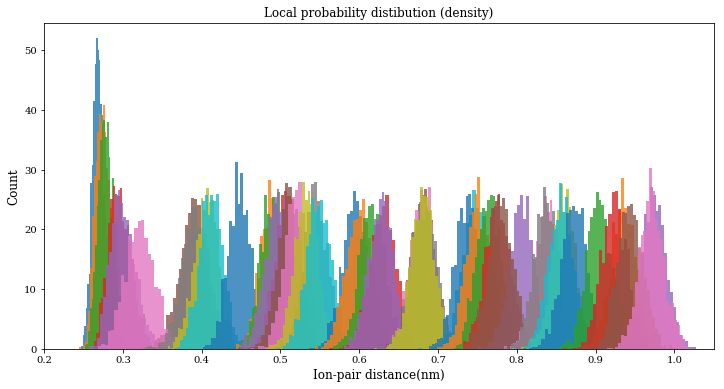

In [95]:
count_n = np.zeros([N, nbins])
prob_n = np.zeros([N, nbins])
bin_edges_n = np.zeros([N, nbins+1])

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
plt.rc('font', family='serif')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6)) 
for i in range(N):
    #count, bin_edges = np.histogram(x_kn[i], bins=nbins, density=True)
    hist_data = plt.hist(x_kn[i], bins=nbins, label='N=%.f' %i,density=True, alpha=0.8)
    plt.xlim([rmin-0.1,rmax+0.1])
    #count_n[i,:] = hist_data[0]
    #prob_n[i,:] = count_n[i,:]/np.sum(count_n[i,:])
    prob_n[i,:] = hist_data[0]
    bin_edges_n[i,:] = hist_data[1]
plt.title('Local probability distibution (density)')
plt.xlabel('Ion-pair distance(nm)', fontsize = '12')
plt.ylabel('Count', fontsize = '12')
plt.xlim([0.2,1.05])
plt.savefig('Section1_histo_x.png', dpi=600)
#plt.legend()

As shown in the figure above, each simuation window has enough overlap with its adjacent neighbors, which allows us to combine information from different umbrella windows. In the cell below, in addition to generate the matrix $\bf{P}$, we also calculate $\bf{U}$. When calculating $\bf{U}$, we have to be careful about the conversion of units. Here we always use $k_{B}T$ as the unit for energy calculation. 
<br> Note that $1k_{B}T=1.38 \times 10^{-23} [\frac{J}{K}] \times 300 [K] \times [\frac{1 kJ}{1000J}] = 4.14 \times 10^{-24} kJ \Rightarrow 1kJ = 2.415 \times 10^{23} k_{B}T$.
<br> Therefore, the force constant $10000$ $kJ/(mol \cdot nm^{2})$ can be converted as follows:
<br> $k = 10000 [\frac{kJ}{mol \times nm^2}] \times \frac{1}{6.022 \times 10^{23}}[\frac{mol}{1}] = 1.66 \times 10^{-21} [\frac{kJ}{nm^{2}}] \times (2.415 \times 10^{23}) [\frac{k_{B}T}{kJ}] = 4010.3 [\frac{k_{B}T}{nm^{2}}]$

In [96]:
k = (10000/(6.022e23))*(1/(1.38e-23*300))*1000 # Turn k = 10000 kJ/(mol*nm^2) into 4010.3 kBT/nm^2
def u(k, x, xc):
    return 0.5*k*(x-xc)**2   # [u] = kBT

p_x, p_xc, P = np.zeros([K*N]),  np.zeros([K*N]), np.zeros([K*N])
n_x = np.zeros([K*N,1])
Xr = np.array(X).ravel()
Xcr = np.array(Xc).ravel()
u_x = u(k, Xr, Xcr)
U = u_x
n = (np.floor(np.arange(0,K*N)/K)+1).astype(int)  # which biasing potential
for n in range(N):
    ranges = np.arange(n*K,(n+1)*K)
    index_x = np.digitize(Xr[ranges],bin_edges_n[n])-1
    index_xc = np.digitize(Xcr[ranges],bin_edges_n[n])-1
    # need to map things back into the range if too far. We assume mu is OK.
    index_x[index_x == nbins] = nbins-1
    index_x[index_x == -1] = 0
    p_x[ranges] = [prob_n[n][i] for i in index_x]
    p_xc[ranges] = [prob_n[n][i] for i in index_xc]
    P[ranges]= -np.log(p_x[ranges]/p_xc[ranges])   # unit: kBT
y = P - U

#### 1.4.3 Calculation and optimization of PMF

In the least-squares esimator, the sum of residuals ($\chi^{2}=\sum^{M}_{m=1}\epsilon_{m}^{2}$) is minimized with respect to the coefficients $a_{m}$. In the matrix form, $\chi^{2}=\bf{\epsilon}^{T}\bf{\epsilon}$ and $\bf{\epsilon=y-Ma}$. Therefore,

$\chi^{2}=(\bf{{y}}^{T}-\bf{a^{T}M^{T}})(\bf{y-Ma}) = \bf{{y}}^{T}y-\bf{y^{T}Ma}-\bf{a^{T}M^{T}y}+\bf{a^{T}M^{T}Ma}$



To determine the optimal solution, we have $\frac{\partial {\chi^{2}}}{\partial{\bf{a}}} = -2\bf{M}^{T}\bf{y}+2\bf{M}^{T}\bf{Ma}=0 \Rightarrow \bf{M^{T}Ma}=\bf{M^{T}y}$

Finally, $\bf{a}=\bf{(M^{T}M)}^{-1}\bf{M^{T}y}$ and can be generated as follows. With $\bf{a}$, we can calculate the residual error $\bf{\epsilon = y-Ma}$ and the PMF: $W(x)=\sum_{m=1}^{M}a_{m}g_{m}(x)$
<br> Below, to evaluate the regression model, we compare the PMF obtained from MLR with the PMF obtained from WHAM euqations as follows.
<br> First, we read in the PMF data by WHAM from `wham_profile.xvg`.

In [107]:
d, f_wham = [], []
infile = open('Section 1/wham_profile.xvg', 'r')                     # data of umbrella sampling (WHAM)
lines = infile.readlines()
infile.close()
# Parse data.
n = 0
m = 0
for line in lines:
    if line[0] == '#' or line[0] == '@':
        m +=1 #number of parameter lines

for line in lines[m:]:  # read in data starting from (m+1)-th line to the end
    if line[0] != '#' and line[0] != '@':
        tokens = line.split()
        d.append(float(tokens[0]))              # data of ion-pair distance of umbrella sampling (WHAM)
        f_wham.append(float(tokens[1]))

Then, we use `LinearRegression` to fit the data and calculate the PMF curve. After that, we plot can compare (use the minimum of the PMF curve as the reference).

The R-squared value is: 0.9057435406550327


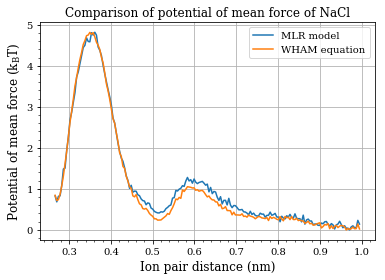

In [108]:
# a1 = np.linalg.inv(M.T.dot(M)).dot(M.T).dot(y)
# a2 = np.linalg.solve(M.T.dot(M), M.T).dot(y)  # better than using np.linalg.inv (same results though)
# refer to: https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li
# a3 = np.linalg.lstsq(M,y)[0] # The result obtained here is the same as using sklearn.LinearRegression without fitting intercepts
reg = LinearRegression(fit_intercept=False)
a = reg.fit(M, y).coef_ # same as a1, a2, and a3

#def W(x):          # calculate the elements of W (PMF data)
#    W = np.zeros(len(x))
#    for i in range(len(x)):
#        w_comp = 0   # = a1g1 + a2g2 + a3g3 + ... change positions!
#        for j in range(N):
#            w_comp = w_comp + a[j]*g(x[i], mu[j], width)  # substite i-th x data into ajgj
#            W[i] = w_comp
#    return W     # unit: kBT

# The following: use reg.predict
d = d[5:190]
input_data = np.zeros([len(d), G])
# Here we truncate the data for the sake of alignment
for i in range(G):
    input_data[:,i] = g(d,mu[i],width)
f_mlr = reg.predict(input_data)   # from regression model but with same range as used in wham_profile.xvg

# Now set the minimum of PMF as the zero  
f_wham = f_wham[5:190]
f_mlr -= np.min(f_mlr)
f_wham -= np.min(f_wham)

# Plotting!
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
plt.rc('font', family='serif')

plt.figure()
plt.title('Comparison of potential of mean force of NaCl')
plt.plot(d,f_mlr, label='MLR model')
plt.plot(d,f_wham, label='WHAM equation')
#plt.xlim([2,10])
plt.minorticks_on()
plt.tick_params(axis='x', which='minor', direction='out')
plt.legend()
plt.xlabel('Ion pair distance (nm)', fontsize = '12')
plt.ylabel('Potential of mean force ($k_{B}T$)', fontsize = '12')
plt.grid()
#plt.savefig('PMF_MLR.png', dpi=600)
print('The R-squared value is:', reg.score(M,y))

As shown in the figure, we can see that the multiple linear regression did a good job, with a decent R-squared value, since it is pretty close the PMF curve obtained from the WHAM equation. However, it might be worthy to optimize the relevant parameters such as the number of bins, number of Gaussians and number of data points extracted from each umbrella window, to make the R-squared value even closer to 1. Note that the problem could be non-linear regression instead of linear regression, but here we will just consider changing one parameter at a time and holding others constant, given that the result is actually already good enough. In the upcoming cells, we will use the following quantity to evaluate the regression model of different parameters used and to find a better set of parameters.
- Root-mean-squared error (RMSE): $RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N}(y_{i}-\hat{y_{i}})^{2}}$
- R-squared value


Since we have multiple paramters to tune, it is worthy to rewrite the calculation of a PMF to a function.

In [109]:
def computePMF(K, nbins, G):
    random.seed(2020)
    N = 47 # number of umbrellas
    Nmax = 3770 # don't hard code.
    rmin = 0.25
    rmax = 1.00
    width = (rmax-rmin)/G  # width of the Gaussian-basis function

    # Allocate storage for simulation data
    x_kn = np.zeros([N,K]) # x_kn[k,n] is the m-th data point of ion-pair distance (in nm) from the n-th umbrella simulation
    xc = np.zeros(N) # xc_kn[k,n] is the center location (in nm) for the n-th umbrella window (all k points have same mu)
    xc_kn = np.zeros([N,K]) # xc_kn[k,n] is the center location (in nm) for the n-th umbrella window (all k points have same mu)
    mu_kg = np.zeros([G,K])
    
    pull_data = np.zeros([N,Nmax])
    for n in range(N):
        # Read ion-pair distance data.
        filename = 'Section 1/pullx-umbrella%d.xvg' % n
        infile = open(filename, 'r')
        lines = infile.readlines()
        infile.close()
        # Parse data.
        i = 0
        j = 0
        for line in lines:
            if line[0] == '#' or line[0] == '@':
                j +=1 #number of parameter lines

        for line in lines[j:j+Nmax]: #read in data starting from (j+1)-th line and read in 5000 lines in total (read in 5000 points)
            if line[0] != '#' and line[0] != '@':
                tokens = line.split()
                dist = float(tokens[1]) # ion-pair distance
                pull_data[n,i] = dist
                i += 1 
                
    for i in range(N):
        x_kn[i,:] = random.choices(pull_data[i], k=K)   # pull_data[i] --> dataset for umbrella i
    X = x_kn.reshape(1, K*N)

    center = np.zeros(N)
    for i in range(N):
        center[i] = pull_data[i][0]

    for n in range(N):
        xc[n] = pull_data[n][0]
        xc_kn[n] = xc[n]

    Xc = xc_kn.reshape(1, K*N)

    i=0
    mu = np.linspace(rmin,rmax,G)
    for n in range(G):
        mu_kg[i] = mu[n]
        i+=1
    Mu = mu_kg.reshape(1,K*G)

    def g(x, mu, sigma):
        return np.exp(-(x-mu)**2/(2*sigma**2))

    M1 = np.zeros([K*N, G])
    M2 = np.zeros([K*N, G])
    for j in range(G):
        M1[:,j] = g(X[0][:], mu[j], width)
        M2[:,j] = g(Xc[0][:], mu[j], width)
    M = M1 - M2
    
    k = (10000/(6.022e23))*(1/(1.38e-23*300))*1000 # Turn k = 10000 kJ/(mol*nm^2) into 4010.3 kBT/nm^2
    def u(k, x, xc):
        return 0.5*k*(x-xc)**2   # [u] = kBT

    prob_n = np.zeros([N, nbins])
    bin_edges_n = np.zeros([N, nbins+1])
    for i in range(N):
        hist_data = np.histogram(x_kn[i], bins=nbins,density=True)
        prob_n[i,:] = hist_data[0]
        bin_edges_n[i,:] = hist_data[1]
    
    
    p_x, p_xc, P = np.zeros([K*N]),  np.zeros([K*N]), np.zeros([K*N])
    n_x = np.zeros([K*N,1])
    Xr = np.array(X).ravel()
    Xcr = np.array(Xc).ravel()
    u_x = u(k, Xr, Xcr)
    U = u_x
    n = (np.floor(np.arange(0,K*N)/K)+1).astype(int)  # which biasing potential
    for n in range(N):
        ranges = np.arange(n*K,(n+1)*K)
        index_x = np.digitize(Xr[ranges],bin_edges_n[n])-1
        index_xc = np.digitize(Xcr[ranges],bin_edges_n[n])-1
        # need to map things back into the range if too far. We assume mu is OK.
        index_x[index_x == nbins] = nbins-1
        index_x[index_x == -1] = 0
        p_x[ranges] = [prob_n[n][i] for i in index_x]
        p_xc[ranges] = [prob_n[n][i] for i in index_xc]
        P[ranges]= -np.log(p_x[ranges]/p_xc[ranges])   # unit: kBT
    y = P - U
    
    d, f_wham = [], []
    infile = open('Section 1/wham_profile.xvg', 'r')                     # data of umbrella sampling (WHAM)
    lines = infile.readlines()
    infile.close()
    # Parse data.
    n, m = 0, 0
    for line in lines:
        if line[0] == '#' or line[0] == '@':
            m +=1 #number of parameter lines

    for line in lines[m:]:  # read in data starting from (m+1)-th line to the end
        if line[0] != '#' and line[0] != '@':
            tokens = line.split()
            d.append(float(tokens[0]))              # data of ion-pair distance of umbrella sampling (WHAM)
            f_wham.append(float(tokens[1]))

    
    reg = LinearRegression(fit_intercept=False)
    a = reg.fit(M, y).coef_ # same as a1, a2, and a3

    input_data = np.zeros([len(d[5:190]), G])
    # Here we truncate the data for the sake of alignment
    for i in range(G):
        input_data[:,i] = g(d[5:190],mu[i],width)
    f_mlr = reg.predict(input_data)   # from regression model but with same range as used in wham_profile.xvg

    # Now set the minimum of PMF as the zero  
    f_wham = f_wham[5:190]
    f_mlr -= np.min(f_mlr)
    f_wham -= np.min(f_wham)
    

    R2 = reg.score(M,y)
    RMSE = (np.sqrt(np.sum((f_wham-f_mlr)**2)/len(f_wham)))
    
    return f_wham, R2, RMSE

computePMF = np.vectorize(computePMF)   # vectorize the function

Now let's tune the three chosen parameters!

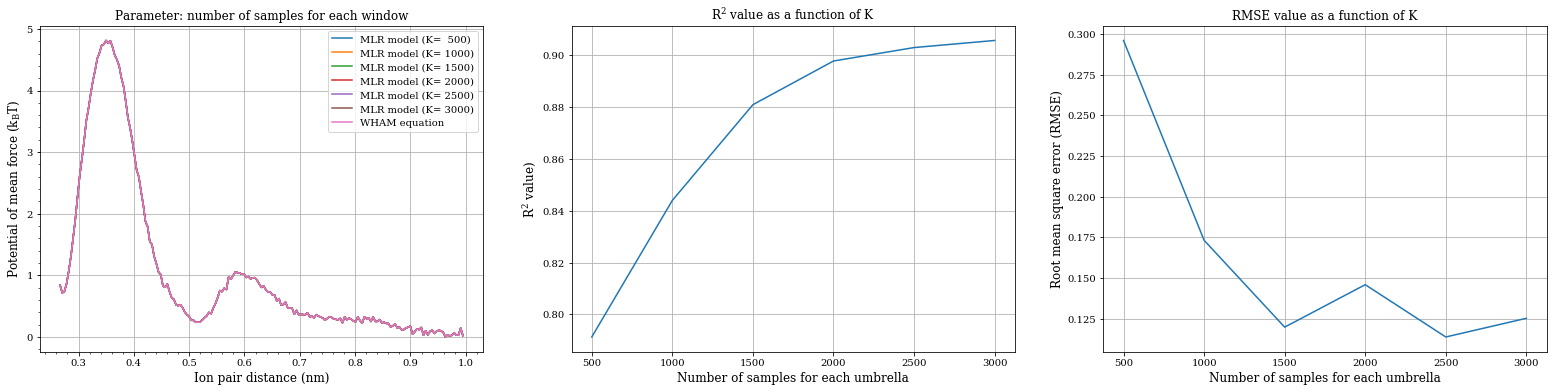

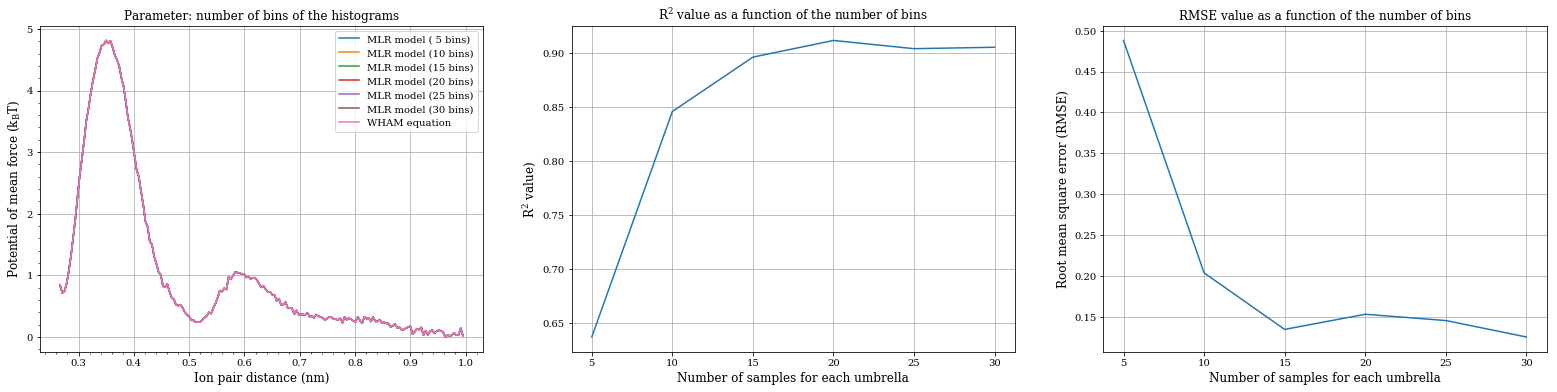

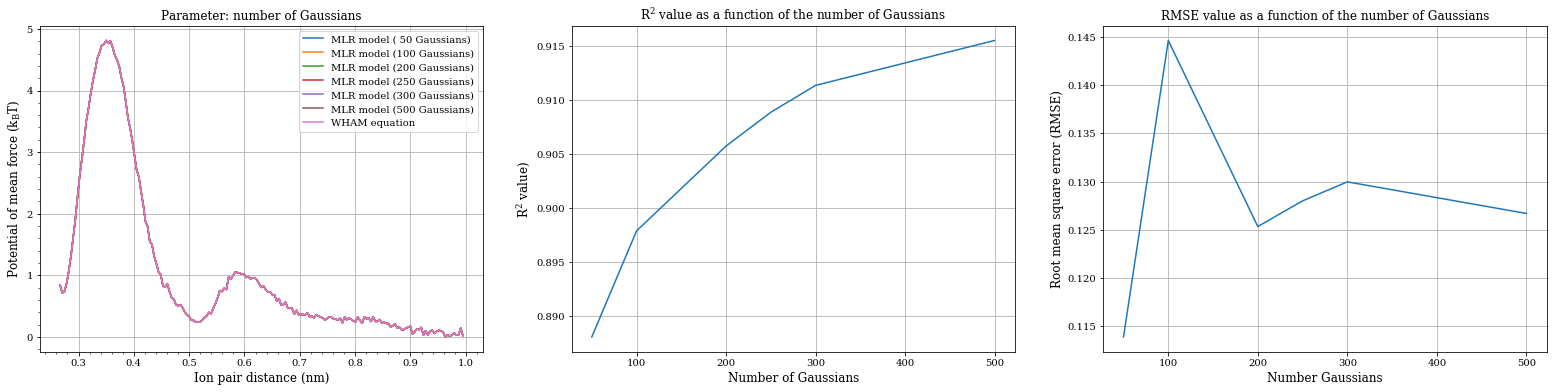

In [122]:
# It should take a few minutes to run this cell
import warnings
warnings.filterwarnings("ignore")  # just remove the warnings about using plt.hold

K_list = [500, 1000, 1500, 2000, 2500, 3000]
nbin_list = [5, 10, 15, 20, 25, 30]
G_list = [50, 100, 200, 250, 300, 500]
f_wham -= np.min(f_wham)

# parameter: K------------------------------------------------------------------------------------------
R2, RMSE = [], []
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27,6))  
for i in range(len(K_list)):
    output1, output2, output3 = computePMF(K_list[i], 30, 200)
    output1 -= np.min(output1)
    plt.subplot(1,3,1)
    plt.title('Parameter: number of samples for each window')
    plt.plot(d,output1, label='MLR model (K=%5d)' %K_list[i])
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', direction='out')
    plt.legend()
    plt.xlabel('Ion pair distance (nm)', fontsize = '12')
    plt.ylabel('Potential of mean force ($k_{B}T$)', fontsize = '12')
    plt.grid(True)
    plt.hold(True)
    R2.append(output2)
    RMSE.append(output3)
plt.plot(d,f_wham, label='WHAM equation')  
plt.legend()

plt.subplot(1,3,2)
plt.title('$R^{2}$ value as a function of K')
plt.plot(K_list, R2)
plt.xlabel('Number of samples for each umbrella', fontsize = '12')
plt.ylabel('$R^{2}$ value)', fontsize = '12')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('RMSE value as a function of K')
plt.plot(K_list, RMSE)
plt.xlabel('Number of samples for each umbrella', fontsize = '12')
plt.ylabel('Root mean square error (RMSE)', fontsize = '12')
plt.grid(True)


# parameter: nbin--------------------------------------------------------------------------------
R2, RMSE = [], []
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27,6)) 
plt.subplot(1,3,1)
for i in range(len(nbin_list)):
    output1, output2, output3 = computePMF(3000, nbin_list[i], 200)
    output1 -= np.min(output1)
    plt.title('Parameter: number of bins of the histograms')
    plt.plot(d,output1, label='MLR model (%2d bins)' %nbin_list[i])
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', direction='out')
    plt.legend()
    plt.xlabel('Ion pair distance (nm)', fontsize = '12')
    plt.ylabel('Potential of mean force ($k_{B}T$)', fontsize = '12')
    plt.grid(True)
    plt.hold(True)
    R2.append(output2)
    RMSE.append(output3)
plt.plot(d,f_wham, label='WHAM equation')  
plt.legend()

plt.subplot(1,3,2)
plt.title('$R^{2}$ value as a function of the number of bins')
plt.plot(nbin_list, R2)
plt.xlabel('Number of samples for each umbrella', fontsize = '12')
plt.ylabel('$R^{2}$ value)', fontsize = '12')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('RMSE value as a function of the number of bins')
plt.plot(nbin_list, RMSE)
plt.xlabel('Number of samples for each umbrella', fontsize = '12')
plt.ylabel('Root mean square error (RMSE)', fontsize = '12')
plt.grid(True)

# parameter: G--------------------------------------------------------------------------------
R2, RMSE = [], []
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27,6)) 
plt.subplot(1,3,1)
for i in range(len(G_list)):
    output1, output2, output3 = computePMF(3000, 30, G_list[i])
    output1 -= np.min(output1)
    plt.title('Parameter: number of Gaussians')
    plt.plot(d,output1, label='MLR model (%3d Gaussians)' %G_list[i])
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', direction='out')
    plt.legend()
    plt.xlabel('Ion pair distance (nm)', fontsize = '12')
    plt.ylabel('Potential of mean force ($k_{B}T$)', fontsize = '12')
    plt.grid(True)
    plt.hold(True)
    R2.append(output2)
    RMSE.append(output3)
plt.plot(d,f_wham, label='WHAM equation')
plt.legend()

plt.subplot(1,3,2)
plt.title('$R^{2}$ value as a function of the number of Gaussians')
plt.plot(G_list, R2)
plt.xlabel('Number of Gaussians', fontsize = '12')
plt.ylabel('$R^{2}$ value)', fontsize = '12')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('RMSE value as a function of the number of Gaussians')
plt.plot(G_list, RMSE)
plt.xlabel('Number Gaussians', fontsize = '12')
plt.ylabel('Root mean square error (RMSE)', fontsize = '12')
plt.grid(True)

From the figure above, it can be seen that the PMF profile basically does not change with different parameters. As the number of data points extracted from each window, number of the bins of each histogram and number of Gaussians increases, the R-squared value tends to increase and the RMSE value tends to decreases, which can be expected. However, all the changes were not significant, indicating that using smaller number of data points, bins of each histogram and Gaussians should be fine. After all the PMF profile is still quite precise. 

#### 1.7 Hypothesis Testing - Kolmogorov-Smirnov test (KS test)

Here, we use a simple KS-test to test whether the probability distribution of each umbrella window follows a normal distribution.

- Null hypothesis $H_{0}$: The probability distribution follows a normal distribution.
- Alternative $H_{a}$: The probability distribution does not follow a normal distribution.

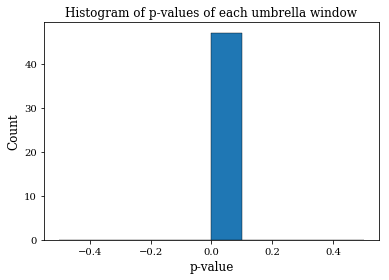

In [123]:
# K-S test
from scipy.stats import kstest
pvalue = np.zeros(N)
for i in range(N):
    D, pvalue[i] = kstest(x_kn[i], 'norm')
plt.hist(pvalue, edgecolor='black', linewidth=0.4)
plt.xlabel('p-value', fontsize = '12')
plt.ylabel('Count', fontsize = '12')
plt.title('Histogram of p-values of each umbrella window')
plt.savefig('histo_pvalue.png', dpi=600)

As shown above, for the local proability distribution of each window, even if they look similar to normal distribution, the p-values are actually all very small (smaller than 0.05), which leads to the rejection of the null hypothesis. That is, the probaiblity distribution of each window is very likely not to follow a normal distribution.

### Section 2. Motion Analysis of Protein Structure by Principal Component Analysis

#### 2.1 Introduction
Charcterized by the excellent ability to reduce dimensions and investigate correlations in large data sets, principal component analysis (PCA) is commonly used to extract useful information from a large scale MD simulation, which produce an immense quantity of data. It is particularly helpful to analyze the motions of flexible regions in proteins, identify systematic conformational changes of a system, detect ill-equlibrated regions of a structure, or compare the motions of two MD trajectories. In this section, we focus on a covalent enzyme-substrate intermediate with saccharide distortion in a mutant Bacteriophage T4 Lysozyme, trying to reveal the motion important motions in the protein (T4 lysozyme). We first explore the system of interst through the visualization of protein structure and its trajectory by using Visual Molecular Dynamics (VMD). Then, we will perform PCA on the trajectory and generate a porcupine plot of the protein to help the interpretation of the result. At last, we will compare different trajectories extract from the PCA to draw some simple conclusions.

#### 2.2 An Overview of the System

As mentioned above, the system of interest is a complex between the bacteriophage T4 lysozyme and a substrate cleaved from the cell wall of Escherichia Coli (E. Coli). The structure of the complex can be acquired from [Protein Data Bank (PDB)](https://www.rcsb.org/) and the only two files (`ref.pdb` and `md1_backbone.xtc`) we need for the analysis in this section were obtained from [Dr. de Groot's Group Website](http://www3.mpibpc.mpg.de/groups/de_groot/) (Max-Planck Institute for Biophysical Chemistry), which were extracted from an 184 ns of MD simulation on the backbone of T4 lysozyme (162 residues). 

To get a better understanding about the structure characteristics of the system before we do the analysis, we use Visual Molecular Dynamics (VMD) to visualize the structures of interest as follows. (For clarity, the water molecules wre removed from the original `148L.pdb`.)

**1. Setup the representations of the system**
<br> By appropriately using representation methods in VMD, characteristics of a structure can be clearly presented. After loading the structure file (`148L.pdb`), we create different representations for different parts of the system, as tabulated below.


|#|Representation |Selection             |Coloring method       |Drawing method|Material|Resolution|
|-|:-------------:|:--------------------:|:---------------------|:-------------|:-------|:---------|
|1|Protein        |Residue 0 to 163      |By secondary structure|NewCartoon    |RTChrome|50        |
|2|Catalytic sites|Residue 11, 20, and 26|By element            |Bonds         |Glossy  |200       |
|3|Substrate      |Resname MUB NAG       |By element            |Bonds         |Glossy  |200       |

** 2. Image generation**

After adjusting to an approriate angle, we display the structures in an orthographic manner and generate figures as below. As can be seen in the left panel The substrate is almost enclosed by the protein. According to the work [[3]](https://science.sciencemag.org/content/262/5142/2030.long) of Kuroki et al. Glu 11, Asp 20 and Glu 26 are the active sites, or catalytic residue of the protein. These residues are shown in bonds representation in the right panel below and there are obviously close to the substrate and buried in the a groove on the protein surface.

<tr>
<td> <img src="Section 2\Figures\system_fig.bmp" style="width: 450px"> </td>
<td> <img src="Section 2\Figures\substrate_fig.bmp" style="width: 450px"> </td>
</tr>

#### 3. Trajectory of the structure

With  trajectory file in `.pdb` format (`t4l.pdb`) which is also accessible from Dr. de Groot's group website, we can also make an animation easily by using VMD, as shown in the left panel below. But if we want to take a look at the trajectory of the backbone atoms, we can still convert `md1_backbone.xtc` we have to convert the trajectory file into `.pdb` format using GROMACS command as follows, with structural infomation provided by `ref.pdb`. (A `.xtc` file only contains coordinate data, while a `.pdb` file only contains structure information like atoms, residues and segment data.)
<br> `gmx_mpi trjconv -s ref.pdb -f md1_backbone.xtc -o md_traj.pdb`
<br> Loading the file `md_traj.pdb`, we can use VMD to obtain the anmiation of the backbone trajectory in the right panel.

<tr>
<td> <img src="Section 2\Figures\structure_gif.gif"> </td>
<td> <img src="Section 2\Figures\backbone_gif.gif"> </td>
</tr>

As shown above, it is really difficult to identify funtionally relevent motions of the structure by simply inspecting the trajectory animation, since both local fluctuations and collective motions occur simultaneously and it is hard to discern the two types of motion from each other. That's why we need the principal component analysis (PCA) to filter global or collective (often slow) motions from local (often) fast motions, which will be introduce in the next section.

#### 2.3 Principal Component Analysis of the Bacteriophage T4 Lysozyme Trajectory

To use Python to perform principal component analyssi (PCA), we first load in the required modules.

In [284]:
import numpy as np
import pandas as pd
import mdtraj as mdt
import mdtraj as md
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from matplotlib import rc

First, load in the trajectory file and align to the initial strutcture (reference).

In [285]:
traj = mdt.load('Section 2/Input files for Python analysis/md1_backbone.xtc', \
                top='Section 2/Input files for Python analysis/ref.pdb')   # supply topology information using .pdb file
# traj = <mdtraj.Trajectory with 1842 frames, 486 atoms, 162 residues, and unitcells at 0x1c5756139e8>
top = traj.topology        # <mdtraj.Topology with 1 chains, 162 residues, 486 atoms, 485 bonds at 0x23d949317b8>
traj.superpose(traj, 0)    # We use the initial structure as the reference

<mdtraj.Trajectory with 1842 frames, 486 atoms, 162 residues, and unitcells at 0x20fb63cc4e0>

And now take a closer look at the funtions in MDtraj and prepare the input data for PCA.

In [286]:
xyz = traj.xyz            # traj.xyz output the cartesian coordinates of backbone at each time frame (from 0th to 2000th)
pca_input = xyz.reshape(traj.n_frames, traj.n_atoms*3)   # transform to the trajectory of all coodinates
print(xyz.shape)
print(pca_input.shape)
print(xyz[0])
print(pca_input[0])

(1842, 486, 3)
(1842, 1458)
[[3.736     2.025     2.6200001]
 [3.7760003 2.1660001 2.628    ]
 [3.6560001 2.25      2.6710002]
 ...
 [4.3240004 2.3470001 1.94     ]
 [4.392     2.219     1.9330001]
 [4.544     2.226     1.9260001]]
[3.736     2.025     2.6200001 ... 4.544     2.226     1.9260001]


Below we projected the data to the first 10 principal components to generate the Scree plot. Then, we plot a scatter plot based on the projected time frames.

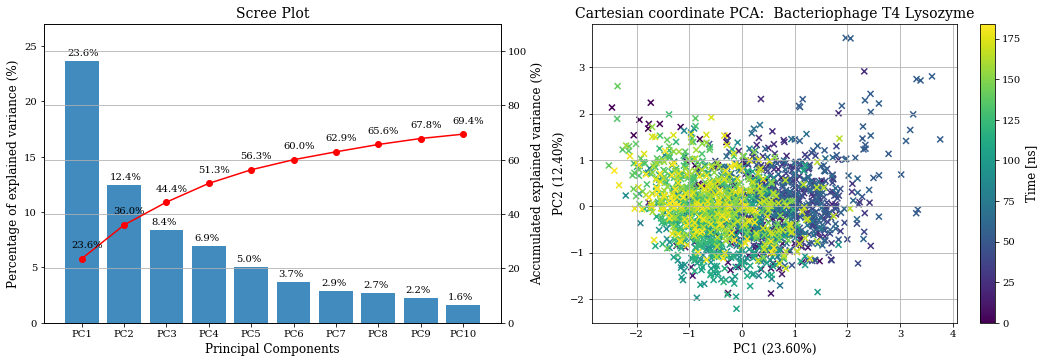

In [287]:
pca = PCA(n_components=10)                            # here n_features = 1458 (=486 x 3)
reduced_coordinates = pca.fit_transform(pca_input)    # dimension reduction of the backbone trajectory (projected to first 10 PCs)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)  # convert into percentages
accum_per_var = [i for i in [np.sum(per_var[:j]) for j in range(1,11)]] # accumulated values of per_var


# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
plt.rc('font', family='serif')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.5))

# Scree plot
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()
ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels, alpha = 0.85)
ax2.plot(range(1,len(per_var)+1), accum_per_var, color = 'r', marker = 'o')
ax2.grid(True)
xlocs, xlabs = plt.xticks()

# adding value labels
for i, v in enumerate(per_var):
    ax1.text(xlocs[i] - 0.35, v+0.5, str(v)+'%')

for i, v in enumerate(accum_per_var):
    ax2.text(xlocs[i] - 0.25, v+4, "{0:.1f}%".format(v))
    
ax1.set_ylabel('Percentage of explained variance (%)', size='12')
ax2.set_ylabel('Accumulated explained variance (%)', size='12')
ax1.set_xlabel('Principal Components', size='12')
ax1.set_ylim([0,27])
ax2.set_ylim([0,110])
plt.title('Scree Plot', size='14')
plt.grid(True)

# Scatter plot  
plt.subplot(1,2,2)
plt.scatter(reduced_coordinates[:, 0], reduced_coordinates[:,1], marker='x', c=traj.time/1000) # plot as a function PC1, PC2
plt.xlabel("PC1 ({0:.2f}%)".format(per_var[0]), size='12')
plt.ylabel("PC2 ({0:.2f}%)".format(per_var[1]), size='12')
plt.title('Cartesian coordinate PCA:  Bacteriophage T4 Lysozyme', size='14')
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Time [ns]', size='12')

As shown in the Scree plot, the first 4 principal components account for over 50% of variance. Although this percentage is not that dominant compared to an ideal case, reducing a dataset of 1458 features to less than 10 principal components still show the funtionality of PCA. In the right panel above, it can be seen that the cluster of projected frames tend to move along the first principal component (PC1) in the negative direction, which might represent apparent conformational changes in the protein within the simulation time.

#### 2.4 Visualization of the Representative Motion of Bacteriophage T4 Lysozyme

To obtain a better understanding about what conformational changes in protein might be within the simulation time, here we analyze the data using GROMACS and generate the porcupine plot of the structure. 

**1. Generation and diagonlization of the covariance matrix**
<br> First, we use the following GROMACS command to calculate and diagonalize the covariance matrix, and yields a set of eigenvectors and eigenvalues that describe collective modes of fluctuations of the protein.
<br> `gmx_mpi covar -s ref.pdb -f md1_backbone.xtc`
<br> The chose all the backbone atoms as the group for the least squares fit and for the covariance analysis. The command outputs four files in total, including `average.pdb`, the file containing the information of the average structure throughout the trajectory, `covar.log`, a file recording the process of performing covariance analysis,  `eigenval.xvg`, a file containing 1458 eigenvalues which can be used to generate the Scree plot (extremely close to what we got in Section 2.3 by using Python), and `eigenvec.trr`, a trjectory file of eigenvectors which can be proceeded to further analysis. 

**2. Analysis of the eigenvectors**
<br> To see what type of motion the individual eigenvectors correspond to, we filter the original trajectory and project out the part along a selected eigenvector by using the following command.
<br> `gmx_mpi anaeig -s ref.pdb -f md1_backbone.xtc -filt filter1.pdb -first 1 -last 1`
By using the flag `-first` and -`last`, we only project the trajectory on the first principal component and `filter1.pdb` is the corresponding trajectory file. We can use the same command the project the trajectory to the second principal component:
<br> `gmx_mpi anaeig -s ref.pdb -f md1_backbone.xtc -filt filter2.pdb -first 2 -last 2`
<br> With `filter1.pdb` and `filter2.pdb`, we can then visualize the trajectory as the left panel below by using VMD.

<tr>
<td> <img src="Section 2\Figures\filter1_gif.gif"> </td>
<td> <img src="Section 2\Figures\filter2_gif.gif"> </td>
</tr>

As shown above the trajectory of the proejction to PC1 exhibit a twist motion, while the trajectory of the projection to PC2 exhibit a closure motion. Therefore, we can know that after binding with the substrate, the motion of T4 lysozyme is mainly composed of twist motion. To further quantify the relationship between the twist motion and the closure motion, we can use the server [DynDom](http://dyndom.cmp.uea.ac.uk/dyndom/) as shown below. As a result, about 76% of the motion can be categorized as twist motion.

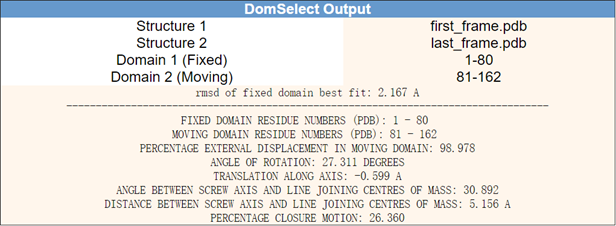

**3. Interpolation of the exreme conformations**

As shown above, the motions of the structure is much less noisy before we project the trajectory data. However, it can also be seen from above that large-scle motions do not occur smoothly, but stochastically. To make the animations smoother, we can artificially interpoloate between the extreme conformations sampled during the simulation along the eigenvector. (Here we interpolate 50 frames between the extreme conformations by using the flag `-nframes`.)
<br> `gmx_mpi anaeig -s ref.pdb -f md1_backbone.xtc -extr extreme1.pdb -first 1 -last 1 -nframes 50`
<br> With the extreme conforations, we can use VMD to plot the porcupine plot to show the difference between extreme conformations and the main direction that the structure was moving. 
- Step 1: To generate a porcupine plot, we should download `Porcuplin.tcl` from [here](http://www.ks.uiuc.edu/Research/vmd/mailing_list/vmd-l/att-15365/PorcupinePlot.tcl) and save the file in the same folder of VMD.
- Step 2: Use a text editor to save the first frame in `extreme1.pdb` to `first_frame.pdb` and save the last frame in `last_frame.pdb`. Then load these to `.pdb` files as new molecules to VMD.
- Step 3: Adjust the representations and the displaying method of the two structures.
- Step 4: Open Tk Console in VMD and type `play Porcupine.tcl` to activate the `.tcl` file.
- Step 5: In the Tk Console, use the command `atomselect 0 "name CA"` and `atomselect 1 "name CA"` to select the first and the last frame, respectively. 
- Step 6: Use the command `porcupineplot::Diff atomselect0 atomselect1` to plot the arrows starting from the first frame to the last frame.
<br> (The extreme conformation can be realized as the conformation at the edge of the structure movement.)

<img src="Section 2\Figures\porcupine_plot.bmp">

As shown above, there is an apparent difference between the two extreme conformations. We can also observe that the two domains tend to get closer to each other.

###  Conclusion

#### Section 1. Free Energy Calculation by Umbrella Sampling and MLR
- MLR is able to give a correct PMF without using WHAM or MBAR equation

#### Section 2. Motion Analysis of Protein Structures by PCA
- PCA can effectively reduce the parameter space of the trajectory of the protein.
- The first 10 principal components account for about 70% of the variance.
- From the plot of PC1 v.s. PC2, we can expect some apparent conformation change occurred during the simulation time.
- Through visualization of the trajectory and inter-domain rotation analysis, we can tell that the motion is mainly composed of twist motion.

### References

- Luca Maragliano and Eric Vanden-Eijnden.Single-sweep methods for free energy calculations. 2008.doi:10.1063/1.2907241. [[1]](https://aip.scitation.org/doi/full/10.1063/1.2907241)
- Yilin Meng and Benoˆıt Roux.Efficient determination of free energy landscapes in multiple dimensionsfrom biased umbrella sampling simulations using linear regression. 2015.doi:10.1021/ct01130r. [[2]](https://pubs.acs.org/doi/abs/10.1021/ct501130r)
- Kuroki, R., Weaver, L., & Matthews, B. (1993). A covalent enzyme-substrate intermediate with saccharide distortion in a mutant T4 lysozyme. Science, 262(5142), 2030-2033. doi:10.1126/science.8266098 [[3]](https://science.sciencemag.org/content/262/5142/2030.long)